In [ ]:
import mphot
import numpy as np
import matplotlib.pyplot as plt

## Dichroic filter generation


Wavelength at min transmission: 909.610 nm
Wavelength at max transmission: 999.299 nm
Width of transition: 89.690 nm
Width of transition (expected): 90.952 nm
Input slope: 10.00 %
Calculated slope: 9.86 %


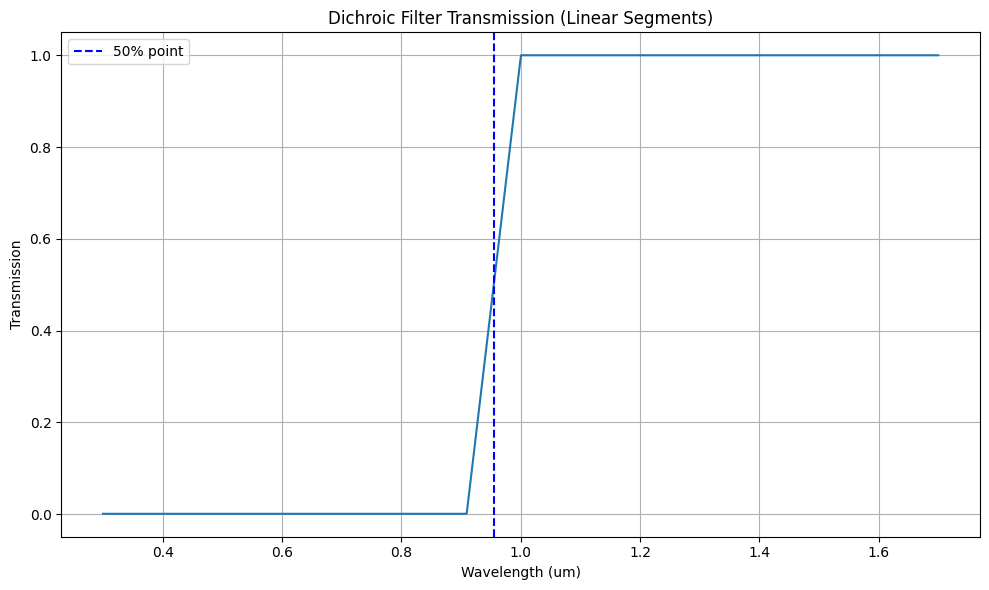

In [ ]:
def dichroic_filter(transition_wavelength, blue_transmission, red_transmission, slope):
    """
    Calculate the transmission of a dichroic filter with a given transition slope.
    :param transition_wavelength: Wavelength at which the transition occurs (um) (at 50% of transmission)
    :param blue_transmission: Transmission in the blue region (0-1)
    :param red_transmission: Transmission in the red region (0-1)
    :param slope: Slope of the transition (%) [𝜆(max) − 𝜆(min)]/𝜆(min) × 100
    :return: (tuple) wavelength (um), Transmission of the dichroic filter (0-1)
    """
    # Generate wavelength range
    wavelength = np.linspace(0.3, 1.7, 1000)

    # Calculate wavelength at min point based on the slope definition
    # slope = [𝜆(max) − 𝜆(min)]/𝜆(min) × 100
    # First, solve for w_min_percent
    # Let's define x = w_min_percent
    # Then: slope/100 = (w_max_percent - x)/x
    # Also, transition_wavelength is at 50% transmission, which is the midpoint
    # between w_min_percent and w_max_percent

    # From the slope definition:
    # w_max_percent = w_min_percent * (1 + slope/100)

    # If transition_wavelength is the 50% point, and assuming linear transition:
    # transition_wavelength = (w_min_percent + w_max_percent)/2
    # transition_wavelength = (w_min_percent + w_min_percent * (1 + slope/100))/2
    # transition_wavelength = w_min_percent * (1 + slope/200)
    # Therefore:
    w_min_percent = transition_wavelength / (1 + slope / 200)
    w_max_percent = w_min_percent * (1 + slope / 100)
    # print(w_max_percent, w_min_percent, 1000 * (w_max_percent - w_min_percent))

    # Create transmission array with linear segments
    transmission = np.zeros_like(wavelength)

    # Determine if it's a rising or falling edge
    rising_edge = red_transmission > blue_transmission

    # Calculate the slopes for the linear segments
    if rising_edge:
        # Fill in blue region (before 5% transition point)
        transmission[wavelength <= w_min_percent] = blue_transmission

        # Fill in transition region (between 5% and 80% points)
        mask_transition = (wavelength > w_min_percent) & (wavelength < w_max_percent)
        # Linear interpolation between 5% and 80% points
        t_range = red_transmission - blue_transmission
        t_0_percent = blue_transmission + 0.0 * t_range
        t_80_percent = blue_transmission + 1.0 * t_range

        # Linear interpolation in the transition region
        transmission[mask_transition] = t_0_percent + (t_80_percent - t_0_percent) * (
            wavelength[mask_transition] - w_min_percent
        ) / (w_max_percent - w_min_percent)

        # Fill in red region (after 80% transition point)
        transmission[wavelength >= w_max_percent] = red_transmission
    else:
        raise NotImplementedError(
            "Falling edge is not implemented in this example. Please implement it if needed."
        )

    return wavelength, transmission


# Example usage
if __name__ == "__main__":
    # Define parameters
    transition_wavelength = 0.955  # Transition wavelength in micrometers
    blue_transmission = 1e-3  # Transmission in the blue region (near 0%)
    red_transmission = 1.0  # Transmission in the red region (100%)
    slope = 10  # Slope of the transition (%)
    w_min_percent = transition_wavelength / (1 + slope / 200)
    w_max_percent = w_min_percent * (1 + slope / 100)
    expected_w_width = w_max_percent - w_min_percent

    # Calculate the dichroic filter transmission
    wavelength, transmission = dichroic_filter(
        transition_wavelength, blue_transmission, red_transmission, slope
    )

    # Calculate transition points from the curve
    # Find the wavelengths at min and max points
    idx_min = ((transmission - blue_transmission * 1.02) > 0).argmax()
    idx_max = np.abs(transmission - red_transmission * 0.98).argmin()

    w_min_percent = wavelength[idx_min]
    w_max_percent = wavelength[idx_max]
    w_width = w_max_percent - w_min_percent

    # Calculate the actual slope
    slope_calc = (w_max_percent - w_min_percent) / w_min_percent * 100

    # Print the results
    print(f"Wavelength at min transmission: {w_min_percent*1000:.3f} nm")
    print(f"Wavelength at max transmission: {w_max_percent*1000:.3f} nm")
    print(f"Width of transition: {w_width*1000:.3f} nm")
    print(f"Width of transition (expected): {expected_w_width*1000:.3f} nm")
    print(f"Input slope: {slope:.2f} %")
    print(f"Calculated slope: {slope_calc:.2f} %")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, transmission)
    # plt.axvline(x=w_min_percent, color="r", linestyle="--", label="5% point")
    # plt.axvline(x=w_max_percent, color="g", linestyle="--", label="80% point")
    plt.axvline(x=transition_wavelength, color="b", linestyle="--", label="50% point")
    plt.title("Dichroic Filter Transmission (Linear Segments)")
    plt.xlabel("Wavelength (um)")
    plt.ylabel("Transmission")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [162]:
# generate filters

transition_wavelength = 0.955  # Transition wavelength in micrometers
blue_transmission = 1e-4  # Transmission in the blue region (near 0%)
red_transmission = 1.0  # Transmission in the red region (100%)

slopes = np.arange(0.00, 20.5, 0.5)  # Slope of the transition (%)
for slope in slopes:
    # slope = 2.5  # Slope of the transition (%)
    w_min_percent = transition_wavelength / (1 + slope / 200)
    w_max_percent = w_min_percent * (1 + slope / 100)
    expected_w_width = (w_max_percent - w_min_percent) * 1000

    filename = f"../resources/filters/dichroic_options/transition_{transition_wavelength:.3f}--slope_{slope:.2f}--blue_{blue_transmission:.6f}--red_{red_transmission:.3f}--width_{expected_w_width:.2f}.csv"

    # Calculate the dichroic filter transmission
    wavelength, transmission = dichroic_filter(
        transition_wavelength, blue_transmission, red_transmission, slope
    )

    # Save the filter data to a CSV file
    with open(filename, "w") as f:
        for w, t in zip(wavelength, transmission):
            f.write(f"{w},{t}\n")

## PWV effect evaluation


`/opt/homebrew/Caskroom/miniconda/base/envs/mphot_pip/lib/python3.11/site-packages/mphot/datafiles/system_responses/speculoos_PIRT_1280SciCam_-60_transition_0.955--slope_0.00--blue_0.000100--red_1.000--width_0.00_zYJ_instrument_system_response.csv` has been generated and saved!
`/opt/homebrew/Caskroom/miniconda/base/envs/mphot_pip/lib/python3.11/site-packages/mphot/datafiles/system_responses/speculoos_PIRT_1280SciCam_-60_transition_0.955--slope_0.50--blue_0.000100--red_1.000--width_4.76_zYJ_instrument_system_response.csv` has been generated and saved!
`/opt/homebrew/Caskroom/miniconda/base/envs/mphot_pip/lib/python3.11/site-packages/mphot/datafiles/system_responses/speculoos_PIRT_1280SciCam_-60_transition_0.955--slope_1.00--blue_0.000100--red_1.000--width_9.50_zYJ_instrument_system_response.csv` has been generated and saved!
`/opt/homebrew/Caskroom/miniconda/base/envs/mphot_pip/lib/python3.11/site-packages/mphot/datafiles/system_responses/speculoos_PIRT_1280SciCam_-60_transition_0.955-

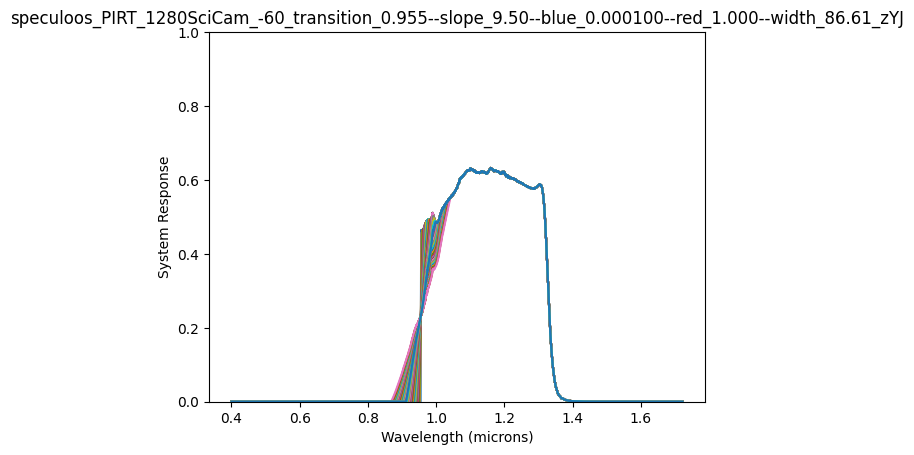

In [264]:
from glob import glob

instrument_efficiency_paths = sorted(
    glob("../resources/systems/dichroic_options/*.csv")
)
filter_path = (
    "../resources/filters/zYJ.csv"  # index in microns, filter efficiency as fraction
)

names = []
for instrument_efficiency_path in instrument_efficiency_paths:
    # Generate the system response
    name, system_response = mphot.generate_system_response(
        instrument_efficiency_path, filter_path
    )
    names.append(name)
    system_response.plot(
        xlabel="Wavelength (microns)", ylabel="System Response", title=name, ylim=(0, 1)
    )

In [265]:
pwvs = np.arange(0.05, 20, 10)  # [mm]
teffs = np.arange(2000, 6500, 4000)  # [K]

# sky properties
props_sky = {
    "pwv": 2.5,  # PWV [mm]
    "airmass": 1.1,  # airmass
    "seeing": 1.35,  # seeing (==FWHM) ["]
}

# instrument properties
props_instrument = {
    "name": "",  # name to get SR/precision grid from file
    "plate_scale": 0.31,  # pixel plate scale ["]
    "N_dc": 110,  # dark current [e/pix/s]
    "N_rn": 90,  # read noise [e_rms/pix]
    "well_depth": 56000,  # well depth [e/pix]
    "well_fill": 0.7,  # fractional value to fill central target pixel, assuming gaussian (width function of seeing^)
    "read_time": 0.1,  # read time between images [s]
    "r0": 0.5,  # radius of telescope's primary mirror [m]
    "r1": 0.14,  # radius of telescope's secondary mirror [m]
    # "min_exp" : 0,          # optional, minimum exposure time [s]
    # "max_exp" : 120,        # optional, maximum exposure time [s]
    # "ap_rad" : 3            # optional, aperture radius [FWHM, seeing] for photometry -- 3 default == 7 sigma of Gaussian
}

# target properties
# Teff = 2566  # [K]
distance = 12.5  # [pc]

In [266]:
results = {}
for name in names:
    fluxes = {}
    for Teff in teffs:
        fluxes[Teff] = {}
        for pwv in pwvs:
            props_sky["pwv"] = pwv
            props_instrument["name"] = name
            image_precision, binned_precision, components = mphot.get_precision(
                props_instrument,
                props_sky,
                Teff,
                distance,
                extended=False,
                SPCcorrection=False,
            )
            fluxes[Teff][pwv] = components["N_star [e/s]"]

    results[name] = fluxes

# Teff_high_delta_flux = fluxes[teffs[-1]][pwvs[-1]] / fluxes[teffs[-1]][0.05]
# Teff_low_delta_flux = fluxes[teffs[0]][pwvs[-1]] / fluxes[teffs[0]][0.05]

Text(0, 0.5, 'Flux difference * (1 - Teff_low_delta_flux)')

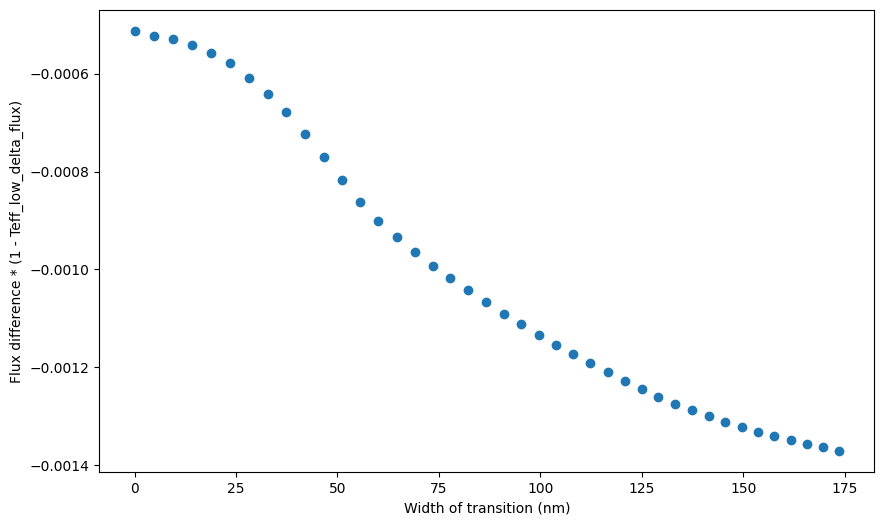

In [267]:
widths = []
diffs = []
for result in results:
    # print(result)
    fluxes = results[result]
    Teff_high_delta_flux = fluxes[teffs[-1]][pwvs[-1]] / fluxes[teffs[-1]][0.05]
    Teff_low_delta_flux = fluxes[teffs[0]][pwvs[-1]] / fluxes[teffs[0]][0.05]
    # print(1 - Teff_low_delta_flux)
    diff = (Teff_high_delta_flux - Teff_low_delta_flux) * (1 - Teff_low_delta_flux)

    width = float(result.split("_")[-2])
    widths.append(width)
    diffs.append(diff)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(widths, diffs, marker="o")
plt.xlabel("Width of transition (nm)")
plt.ylabel("Flux difference * (1 - Teff_low_delta_flux)")
# plt.ylim(-0.01, 0.01)

## Single PWV effect evaluation


`/opt/homebrew/Caskroom/miniconda/base/envs/mphot_pip/lib/python3.11/site-packages/mphot/datafiles/system_responses/speculoos_PIRT_1280SciCam_-60_transition_0.955--slope_9.50--blue_0.000100--red_1.000--width_86.61_YJ_instrument_system_response.csv` has been generated and saved!


<Axes: title={'center': 'speculoos_PIRT_1280SciCam_-60_transition_0.955--slope_9.50--blue_0.000100--red_1.000--width_86.61_YJ'}, xlabel='Wavelength (microns)', ylabel='System Response'>

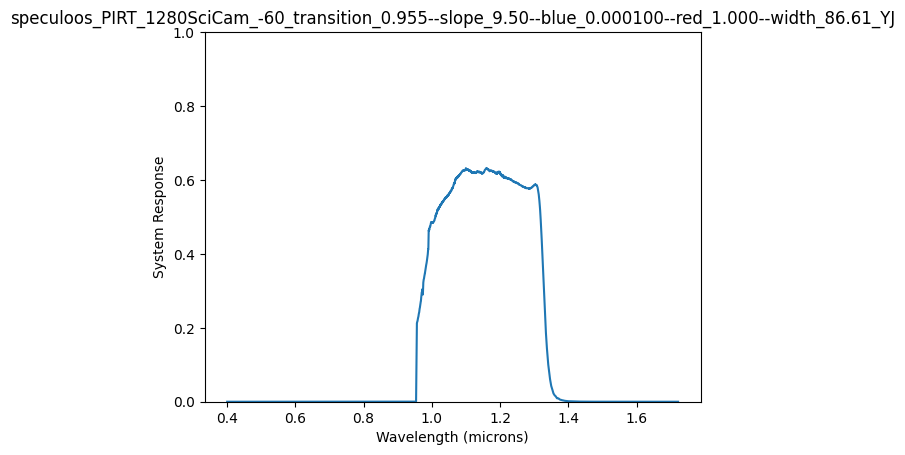

In [259]:
instrument_efficiency_paths = sorted(
    glob("../resources/systems/dichroic_options/*.csv")
)
instrument_efficiency_path = instrument_efficiency_paths[-1]
filter_path = (
    "../resources/filters/YJ.csv"  # index in microns, filter efficiency as fraction
)
# Generate the system response
name, system_response = mphot.generate_system_response(
    instrument_efficiency_path, filter_path
)
names.append(name)
system_response.plot(
    xlabel="Wavelength (microns)", ylabel="System Response", title=name, ylim=(0, 1)
)

In [260]:
pwvs = np.arange(0.05, 20, 0.5)  # [mm]
teffs = np.arange(2000, 6500, 500)  # [K]

# sky properties
props_sky = {
    "pwv": 2.5,  # PWV [mm]
    "airmass": 1.1,  # airmass
    "seeing": 1.35,  # seeing (==FWHM) ["]
}

# instrument properties
props_instrument = {
    "name": name,  # name to get SR/precision grid from file
    "plate_scale": 0.31,  # pixel plate scale ["]
    "N_dc": 110,  # dark current [e/pix/s]
    "N_rn": 90,  # read noise [e_rms/pix]
    "well_depth": 56000,  # well depth [e/pix]
    "well_fill": 0.7,  # fractional value to fill central target pixel, assuming gaussian (width function of seeing^)
    "read_time": 0.1,  # read time between images [s]
    "r0": 0.5,  # radius of telescope's primary mirror [m]
    "r1": 0.14,  # radius of telescope's secondary mirror [m]
    # "min_exp" : 0,          # optional, minimum exposure time [s]
    # "max_exp" : 120,        # optional, maximum exposure time [s]
    # "ap_rad" : 3            # optional, aperture radius [FWHM, seeing] for photometry -- 3 default == 7 sigma of Gaussian
}

# target properties
# Teff = 2566  # [K]
distance = 12.5  # [pc]

In [261]:
fluxes = {}
for Teff in teffs:
    fluxes[Teff] = {}
    for pwv in pwvs:
        props_sky["pwv"] = pwv
        props_instrument["name"] = name
        image_precision, binned_precision, components = mphot.get_precision(
            props_instrument,
            props_sky,
            Teff,
            distance,
            extended=False,
            SPCcorrection=False,
        )
        fluxes[Teff][pwv] = components["N_star [e/s]"]

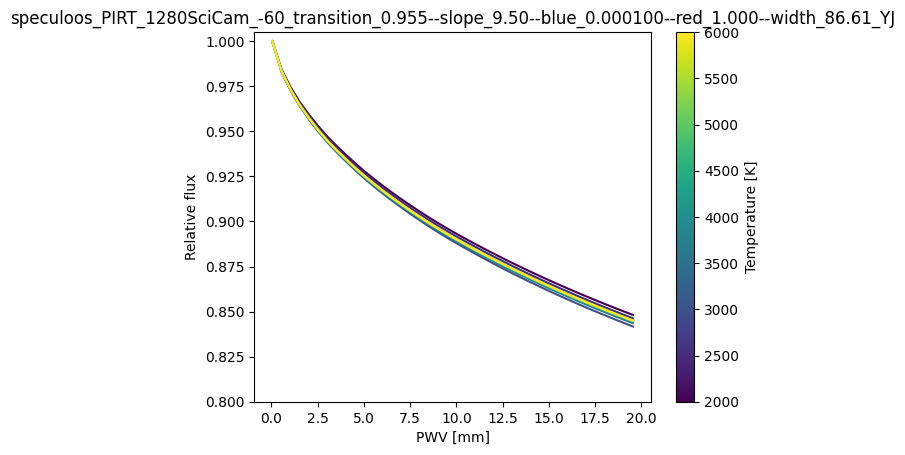

In [262]:
# plot relative flux vs PWV for each Teff, where relative flux is flux / flux_0, where flux_0 is the flux at 0.05 mm per Teff
fig, ax = plt.subplots()
norm = plt.Normalize(vmin=teffs.min(), vmax=teffs.max())
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for Teff in teffs:
    ax.plot(
        pwvs,
        [fluxes[Teff][pwv] / fluxes[Teff][0.05] for pwv in pwvs],
        label=f"{Teff} K",
        color=cmap(norm(Teff)),
    )

ax.set_ylim(0.8, 1.005)
ax.set_xlabel("PWV [mm]")
ax.set_ylabel("Relative flux")
ax.set_title(f"{name}")
fig.colorbar(sm, ax=ax, label="Temperature [K]")